In [48]:
__author__ = ["Anuj Mishra <anuj.mishra@ligo.org>"]

import numpy as np
from scipy.interpolate import interp1d
from copy import deepcopy
import os

import lal
import pycbc
from pycbc import types, waveform
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.detector import Detector
from pycbc.frame import frame
import pycbc.noise
import pycbc.psd

import sys
sys.path.append('../gwmat/')
from point_lens import PointLens
from cosmology import Cosmology
from gw_analysis import GWAnalysis
from utils import MiscFuncs
from constants import *

# cwd = os.path.dirname(__file__) + '/'
cwd = '../gwmat/'
    
class GWSignalGeneration(PointLens, Cosmology, GWAnalysis, MiscFuncs):
    """
    Contains functions related to GW signal generation (microlensed or unlensed) and injection (with or w/o noise), snr computations, snr_to_distance estimates, etc.
    
    # An example dict for this class with default values:
    init_prms = dict(f_start=20, f_low=20., f_high=None, f_ref=20., sample_rate=2048, wf_approximant="IMRPhenomXPHM", ifo_list = ['H1', 'L1', 'V1'])
    lens_prms = dict(m_lens=0., y_lens=5., z_lens=0., Ff_data=None)
    cbc_prms =  dict(mass_1=m1, mass_2=m2, a_1=a_1, a_2=a_1, tilt_1=tilt_1, tilt_2=tilt_2, 
                phi_jl=phi_jl, phi_12=phi_12, theta_jn=theta_jn, luminosity_distance=dist, 
                ra=0., dec=0., polarization=0., coa_phase=0., trigger_time=0.,  
                mode_array=None, lambda1=None, lambda2=None, rwrap = 0.)
    misc_prms = dict(save_data=False, data_outdir = './', data_label='data', data_channel='PyCBC-Injection')            
    psd_prms = dict(Noise=True, psd_H1=psd_H1, psd_L1=psd_L1, psd_V1=psd_V1, noise_seed=127)   #for no-noise, comment this line or set Noise=False.
    where, if Noise == {True, 'True', 'true'} then noise will be added based on provided files for each detector, 
    i.e., psd_H1 = Path to the file containing PSD information of H1 detector, and so on.

    prms = {**init_prms, **lens_prms, **cbc_prms, **psd_prms, **misc_prms}
    
    Caution: Provide data in either the L-frame or J-frame (explained below). Not both!

    prms : 
    Dictionary of:

        Initial basic prms:

            * f_start : ({20., float}), optional 
                Starting frequency for the waveform generation (in Hz). 
                For Time-Domain WF models, f_start is the starting frequency of the (l=2, m=2) mode. 
                For Frequency-Domain WF models, f_start corresponds to the lowest frequency from where all the available modes in the model start. 
                For example, if one wants to generate the WF contaning all modes upto l=4 from 20Hz, then for TD models, f_start <= 20 * (2/4) = 10, while for FD models, f_start<=20.     
            * f_low : ({20., float}), optional 
                Lower frequency considered for analysis (in Hz). For example, SNR calculation will use this f_low. 
            * f_high : ({None., float}), optional 
                Maximum frequency for matched filter computations (in Hz).     
            * f_ref : ({20., float}), optional  
                Reference frequency (in Hz). 
            * sample_rate : ({2048, int}), optional   
                Sample rate of WFs to generate. Default = 2048 (works for most of BBH parameters excpet when binary mass < ~20).
            * wf_approximant : str, optional
                Name of LAL WF approximant to use for WF generation. Default="IMRPhenomXP".
            * ifo_list : list of strings
                List of interferometers to consider. Default =  ['H1', 'L1', 'V1']

        Microlensing Parameters:

            * m_lens : ({0.,float}), optional 
                Point-Lens Mass (in solar masses).
            * y_lens : ({5.,float}), optional 
                The dimensionless impact parameter between the lens and the source.
            * z_lens : ({0.,float}), optional. 
                Lens redshift. Default = 0. (i.e., m_lens will then represent the redhifted lens mass.)
            * Ff_data : float, optional 
                F(f) data to use for modifying WF. If given, {m_lens, y_lens, z_lens} will be ignored. Default=None.

        CBC Parameters:

            * mass_1 : float 
                The detector frame mass of the first component object in the binary (in solar masses).
            * mass_2 : float 
                The detector frame mass of the second component object in the binary (in solar masses).
            * mode_array : {None, list of lists}
                Modes to consider while generating WF. Default = None, contains all the modes available in the WF approximant. 
                For specific modes, use: mode_array = [[2,2], [4,4], etc.]    
            * lambda1 : float, optional
                The tidal deformability parameter of the first component object in the binary (in solar masses).
            * lambda2 : float, optional
                The tidal deformability parameter of the second component object in the binary (in solar masses).    

        (J-Frame Coordinates):    

            * a_1 : float, optional
                The dimensionless spin magnitude. 
            * a_2 : float, optional
                The dimensionless spin magnitude. 
            * tilt_1 : ({0.,float}), optional
                Angle between L and the spin magnitude of object 1.
            * tilt_2 : float, optional
                Angle between L and the spin magnitude of object 2.
            * phi_12 : float, optional
                Difference between the azimuthal angles of the spin of the object 1 and 2. 
            * phi_jl : float, optional
                Azimuthal angle of L on its cone about J.     
            * theta_jn : float, optional
                Angle between the line of sight and the total angular momentum J.  

        (L-Frame Coordinates):

            * inclination : float
                Inclination (rad), defined as the angle between the orbital angular momentum L and the
                line-of-sight at the reference frequency. Default = 0.
            * spin1x : float
                The x component of the first binary component. Default = 0.
            * spin1y : float
                The y component of the first binary component. Default = 0.
            * spin1z : float
                The z component of the first binary component. Default = 0.
            * spin2x : float
                The x component of the second binary component. Default = 0.
            * spin2y : float
                The y component of the second binary component. Default = 0.
            * spin2z : float
                The z component of the second binary component. Default = 0.

        Other (Extrinsic) Parameters:  

            * luminosity_distance : ({100.,float}), optional
                Luminosity distance to the binary (in Mpc).
            * ra : ({0.,float}), optional
                Right ascension of the source (in rad).
            * dec : ({0.,float}), optional
                Declination of the source (in rad).
            * polarization : ({0.,float}), optional
                Polarisation angle of the source (in rad).
            * coa_phase : ({0.,float}), optional
                Coalesence phase of the binary (in rad).
            * trigger_time : ({0.,float}), optional
                Trigger time of the GW event (GPS time).
            * rwrap : ({0.,float}), optional
                Cyclic time shift value (in sec).
            
        Noise Parameters:

            * Noise : str, use either of these {True, 'True', 'true'} for setting up the noise.
                Boolian type value indicating whether to add Noise to the projected signals or not.
            * psd_H1, psd_L1, psd_V1 : str 
                Path to the respective PSD files. Default = 'O4' (PSDs corresponding to O4 are pre-saved and linked to the keyword `O4`.)
            * noise_seed: int
                Seed for random Gaussian noise generation.    

        Misc Parameters:
            * save_data : str, use either of these {True, 'True', 'true'} for saving the data.
                A boolian type value to save the detector data as a frame file. Default = False.
            * data_outdir: str
                Output directory where data will be saved. Default = './', i.e., the current directory from where the command will be run.
            * data_label: str
                Data label to use while saving. Default = 'data'.
            * data_channel: str,
                Detector channel name (will be used while reading the data). Default = 'PyCBC_Injection'.
                
    """

    def __init__(self):      
        # These values can be modified by attribute referencing, i.e., after importing via module.class.variable_name = New_Val
        self.f_start = 20.
        self.f_low = 20.
        self.f_high = None
        self.f_ref = 20.
        self.sample_rate = None 
        self.wf_approximant = "IMRPhenomXPHM"
        self.ifo_list = ['H1', 'L1', 'V1']
    
    def generate_lensed_pure_polarized_waveforms(self, **prms): 
        """
        Function to generate pure polarised lensed waveform.

        Parameters
        ----------
        prms : Dictionary of parameters as described in the definition of this class. 
        To quickly generate WFs with default settings, use:
        prms = dict(mass_1=m1, mass_2=m2, luminosity_distance=100, theta_jn=0)


        Returns
        -------
        Dictionary of:
        * lensed_FD_WF_hp, lensed_FD_WF_hc : pycbc.types.FrequencySeries
            Lensed pure polarized frequency-domain (FD) waveforms.
        * lensed_TD_WF_hp, lensed_TD_WF_hc : pycbc.types.TimeSeries
            Lensed pure polarized time-domain (TD) waveforms.
        * unlensed_FD_WF_hp, unlensed_FD_WF_hc : pycbc.types.FrequencySeries
            Unlensed pure polarized frequency-domain (FD) waveforms.        
        * unlensed_TD_WF_hp, unlensed_TD_WF_hp : pycbc.types.TimeSeries
            Unlensed pure polarized time-domain (TD) waveforms.
            
        """        

        prms_default = dict(f_start=self.f_start, f_high=self.f_high, f_ref=self.f_ref, sample_rate=self.sample_rate, 
                        wf_approximant=self.wf_approximant, ifo_list = self.ifo_list,
                        m_lens=0., y_lens=5., z_lens=0., Ff_data=None, 
                        ra=0., dec=0., polarization=0., coa_phase=0., trigger_time=0., 
                        mode_array=None, lambda1=None, lambda2=None, rwrap = -2,
                        wf_domain=None, delta_f=None,
                        )
        prms_default.update(prms)
        prms = prms_default.copy()
        
        # checks if a key exists in the provided dictionary "prms"
        prms_key_bool = lambda x: bool(x in prms.keys())

        # checks if a spin key is provided, otherwise assigns 0.
        lframe_related_keys = np.array(['spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y', 'spin2z', 'inclination'])
        jframe_related_keys = np.array(['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'theta_jn'])

        key_bool_vals_lframe = list(map(prms_key_bool, lframe_related_keys))
        key_bool_vals_jframe = list(map(prms_key_bool, jframe_related_keys))

        # These conditional expressions check if parameters are defined in only one frame (either L-Frame or J-Frame), and to assign default values. 
        if np.sum(key_bool_vals_lframe) > 0 and np.sum(key_bool_vals_jframe) == 0:
            spin_related_keys = lframe_related_keys
            key_bool_vals = key_bool_vals_lframe
            # provided_spin_keys = spin_related_keys[key_bool_vals]
            not_provided_spin_keys = spin_related_keys[[not bool_vals for bool_vals in key_bool_vals]]
            for key in not_provided_spin_keys:
                prms[key] = 0
        elif np.sum(key_bool_vals_lframe) == 0 and np.sum(key_bool_vals_jframe) > 0:
            spin_related_keys = jframe_related_keys
            key_bool_vals = key_bool_vals_jframe
            # provided_spin_keys = spin_related_keys[key_bool_vals]
            not_provided_spin_keys = spin_related_keys[[not bool_vals for bool_vals in key_bool_vals]]
            for key in not_provided_spin_keys:
                prms[key] = 0    
            lframe_dict = self.jframe_to_l0frame(mass_1=prms['mass_1'], mass_2=prms['mass_2'], 
                                           f_ref=prms['f_ref'], phi_ref=prms['coa_phase'], theta_jn=prms['theta_jn'],\
                                           phi_jl=prms['phi_jl'], a_1=prms['a_1'], a_2=prms['a_2'], tilt_1=prms['tilt_1'], tilt_2=prms['tilt_2'], phi_12=prms['phi_12'])  
           
            prms = {**prms, **lframe_dict}  #prms.update(lframe_dict) #{**prms, **lframe_dict}
        elif np.sum(key_bool_vals_lframe) + np.sum(key_bool_vals_jframe) == 0:
            raise Exception('Please provide parameters related to either L-Frame or J-Frame.')
        else:
            raise Exception('Provide parameter values in either the L-Frame or the J-Frame, NOT both!')
        
        if 'approximant' in prms.keys():
            prms['wf_approximant'] == prms['approximant']

        # If wf_domain is None, use the following logic to decide whether to generate in TD or FD:
        if prms['wf_domain'] is None:
            # If generating microlensed WF, check if the provided WF approximant is available in the FD domain. If yes, generate WF in FD.
            if prms['m_lens'] / prms['y_lens'] != 0:
                wf_approximants = self.gw_wf_approximants_in_lal()
                if prms['wf_approximant'] in wf_approximants['fd_approximants']:
                    prms['wf_domain'] = 'FD'
                    if prms['delta_f'] is None:
                        mtot = prms['mass_1'] + prms['mass_2']
                        if mtot<10:
                            prms['delta_f'] = 1/64
                        elif 10<=mtot<20:
                            prms['delta_f'] = 1/32  
                        elif 20<=mtot<35:
                            prms['delta_f'] = 1/16  
                        else:
                            prms['delta_f'] = 1/8                                                            
        else:
            prms['wf_domain'] = 'TD'
            if prms['sample_rate'] is None:
                mtot = prms['mass_1'] + prms['mass_2']
                if mtot<15:
                    prms['sample_rate'] = 8192 # = 2**13
                elif 15<=mtot<35:
                    prms['sample_rate'] = 4096 # = 2**12  
                else:
                    prms['sample_rate'] = 2048 # = 2**11                       

        #Waveform Generation
        if prms['wf_domain'] == 'TD':
            hp, hc = get_td_waveform(
            approximant = prms['wf_approximant'],
            mass1 = prms['mass_1'],
            mass2 = prms['mass_2'],
            spin1x = prms['spin1x'],
            spin1y = prms['spin1y'],
            spin1z = prms['spin1z'],
            spin2x = prms['spin2x'],
            spin2y = prms['spin2y'],
            spin2z = prms['spin2z'],
            lambda1 = prms['lambda1'],
            lambda2 = prms['lambda2'],
            distance =  prms['luminosity_distance'],
            inclination = prms['inclination'],
            coa_phase = prms['coa_phase'],
            mode_array = prms['mode_array'],
            f_lower = prms['f_start'],
            f_ref = prms['f_ref'],
            delta_t = 1./prms['sample_rate'] )

            # performing cyclic time shift to avoid wrapping up of WFs
            hp = self.cyclic_time_shift_of_wf(hp, prms["rwrap"])  #hp.cyclic_time_shift(rwrap)
            hc = self.cyclic_time_shift_of_wf(hc, prms["rwrap"])  #hc.cyclic_time_shift(rwrap)
            tdwf_hp, tdwf_hc = hp, hc

            # generating FD WFs from TD WFs
            fdwf_hp = hp.to_frequencyseries(delta_f=hp.delta_f)
            fdwf_hc = hc.to_frequencyseries(delta_f=hc.delta_f)   

        else:
            hp, hc = get_fd_waveform(
            approximant = prms['wf_approximant'],
            mass1 = prms['mass_1'],
            mass2 = prms['mass_2'],
            spin1x = prms['spin1x'],
            spin1y = prms['spin1y'],
            spin1z = prms['spin1z'],
            spin2x = prms['spin2x'],
            spin2y = prms['spin2y'],
            spin2z = prms['spin2z'],
            lambda1 = prms['lambda1'],
            lambda2 = prms['lambda2'],
            distance =  prms['luminosity_distance'],
            inclination = prms['inclination'],
            coa_phase = prms['coa_phase'],
            mode_array = prms['mode_array'],
            f_lower = prms['f_start'],
            f_ref = prms['f_ref'],
            delta_f = prms['delta_f'] )

            fdwf_hp, fdwf_hc = hp, hc
            # generating TD WFs from FD WFs
            tdwf_hp = fdwf_hp.to_timeseries(delta_t=fdwf_hp.delta_t)
            tdwf_hc = fdwf_hc.to_timeseries(delta_t=fdwf_hc.delta_t)

            # performing cyclic time shift to avoid wrapping up of WFs
            tdwf_hp = self.cyclic_time_shift_of_wf(tdwf_hp, prms["rwrap"])  #hp.cyclic_time_shift(rwrap)
            tdwf_hc = self.cyclic_time_shift_of_wf(tdwf_hc, prms["rwrap"])  #hc.cyclic_time_shift(rwrap)

        # Checks if the amplification factor, F(f), data is provided to modify the WF.
        # The data should be a three columned array containing {frequencies, Re[F(f)], Im[F(f)]}
        if prms['Ff_data'] is not None:   
            Ffs = prms["Ff_data"]
            if np.array(Ffs).size > 1 and np.array(Ffs[0]).size == 3:
                iFf = interp1d(Ffs[:,0], Ffs[:,1] + 1j*Ffs[:,2], kind='linear')
                fs = fdwf_hp.sample_frequencies
                Ff = np.array(list(map(iFf, fs)))
            else:
                raise Exception("Please provide 'Ff_data' in the correct format. The data should be a three columned array containing {frequencies, Re[F(f)], Im[F(f)]}. "\
                                "If you didn't intend using 'Ff_data' but rather point lens parameters, you can set it to 'None'.")
        else:
            m_lens, y_lens, z_lens = prms['m_lens'], prms['y_lens'], prms['z_lens']
            if round(m_lens) == 0:
                res_ul = {'unlensed_FD_WF_hp':fdwf_hp, 'unlensed_FD_WF_hc':fdwf_hc, 'unlensed_TD_WF_hp':hp, 'unlensed_TD_WF_hc':hc}
                res_ml = {'lensed_FD_WF_hp':fdwf_hp, 'lensed_FD_WF_hc':fdwf_hc, 'lensed_TD_WF_hp':hp, 'lensed_TD_WF_hc':hc}
                return {**res_ul, **res_ml} 
            else:
                fs = fdwf_hp.sample_frequencies
                wfs = self.w_of_f(fs, m_lens, z_lens)
                Ff = self.Fw_efficient_map(wfs, y_lens)   

        lfd_hp = Ff * fdwf_hp
        lfdwf_hp = types.FrequencySeries(lfd_hp, delta_f=hp.delta_f)
        ltdwf_hp = lfdwf_hp.to_timeseries(delta_t=hp.delta_t)

        lfd_hc = Ff * fdwf_hc
        lfdwf_hc = types.FrequencySeries(lfd_hc, delta_f=hc.delta_f)
        ltdwf_hc = lfdwf_hc.to_timeseries(delta_t=hc.delta_t)

        # performing cyclic time shift to avoid wrapping up of WFs
        ltdwf_hp = self.cyclic_time_shift_of_wf(ltdwf_hp, prms["rwrap"])  #hp.cyclic_time_shift(rwrap)
        ltdwf_hc = self.cyclic_time_shift_of_wf(ltdwf_hc, prms["rwrap"])  #hc.cyclic_time_shift(rwrap)

        res_ul = {'unlensed_FD_WF_hp':fdwf_hp, 'unlensed_FD_WF_hc':fdwf_hc, 'unlensed_TD_WF_hp':tdwf_hp, 'unlensed_TD_WF_hc':tdwf_hc}
        res_ml = {'lensed_FD_WF_hp':lfdwf_hp, 'lensed_FD_WF_hc':lfdwf_hc, 'lensed_TD_WF_hp':ltdwf_hp, 'lensed_TD_WF_hc':ltdwf_hc}
        return {**res_ul, **res_ml} 
     
    def modify_waveform_start_time(self, wf, extra=1, **prms):
        """
        Function to modify the starting of a WF so that it starts on an integer GPS time (in sec) + add extra length as specified by the user.

        Parameters
        ----------
        wf :  pycbc.types.TimeSeries
            WF whose length is to be modified.
        extra : int, optional
            Extra length to be added in the beginning after making the WF to start from an integer GPS time (in sec). Default = 1.

        Returns
        -------
        pycbc.types.timeseries.TimeSeries
            Modified waveform starting form an integer time.

        """      

        sr = prms['sample_rate']
        olen = len(wf)   
        diff = wf.sample_times[0]-np.floor(wf.sample_times[0])  
        # nlen = round(olen+sr*(extra+diff))
        dlen = round(sr*(extra+diff))
        wf_strain = np.concatenate((np.zeros(dlen), wf))
        t0 = wf.sample_times[0]
        dt = wf.delta_t
        n = dlen
        tnn = t0-(n+1)*dt
        wf_stime = np.concatenate((np.arange(t0-dt,tnn,-dt)[::-1], np.array(wf.sample_times)))
        nwf = pycbc.types.TimeSeries(wf_strain, delta_t=wf.delta_t, epoch=wf_stime[0])
        return nwf

    def modify_waveform_end_time(self, wf, extra=2, **prms): #post_trig_duration
        """
        Function to modify the end of a WF so that it ends on an integer GPS time (in sec) + add extra length as specified by the user.

        Parameters
        ----------
        wf : pycbc.types.TimeSeries
            WF whose length is to be modified.
        extra : int, optional
            Extra length to be added towards the end after making the WF to end from an integer GPS time (in sec). 
            Default = 2, which makes sure post-trigger duration is of at least 2 seconds.

        Returns
        -------
        pycbc.types.timeseries.TimeSeries
            Modified waveform ending on an integer time.

        """        

        sr = prms['sample_rate']
        olen = len(wf)   
        dt = abs(wf.sample_times[-1] - wf.sample_times[-2])
        diff = np.ceil(wf.sample_times[-1]) - (wf.sample_times[-1] + dt)   #wf.sample_times[-1]-int(wf.sample_times[-1])  
        nlen = round(olen + sr*(extra+diff))
        wf.resize(nlen)
        return wf    
    
    def adjust_waveform_length_to_power_of_2(self, wf):
        """
        Function to modify the length of a waveform so that its duration is a power of 2.

        Parameters
        ----------
        wf : pycbc.types.TimeSeries
            WF whose length is to be modified.
            Modified waveform with duration a power of 2.
        Returns
        -------
        pycbc.types.timeseries.TimeSeries
            Returns the waveform with length a power of 2.

        """    

        dur = wf.duration  
        wf.resize( int(round(wf.sample_rate * np.power(2, np.ceil( np.log2( dur ) ) ))) )
        wf = self.cyclic_time_shift_of_wf(wf, rwrap = wf.duration - dur )
        return wf
        
    def generate_simulated_lensed_signals(self, **prms):
        """
        Simulated lensed WF generation projected onto detectors.

        Parameters
        ----------
        prms : Dictionary of parameters as described in the definition of this class. 
        To quickly generate WFs with default settings, use:
        prms = dict(mass_1=m1, mass_2=m2, luminosity_distance=100, theta_jn=0)

        Returns
        -------
        Dictionary of :
        * pure_polarized_wfs : dict 
            A dictionary containing plus and cross polarizaions of WF. keys = ['hp', 'hc'].
        * pure_ifo_signal : dict
            A dictionary containing projected WFs onto detectors without noise. keys = ifo_list.

        """   

        prms_default = dict(f_start=self.f_start, f_high=self.f_high, f_ref=self.f_ref, sample_rate=self.sample_rate, 
                        wf_approximant=self.wf_approximant, ifo_list=self.ifo_list, ra=0., dec=0., polarization=0., trigger_time=0.,
                        extra_padding_at_start=1, extra_padding_at_end=1)
        prms_default.update(prms)
        prms = prms_default.copy()

        # Choose a GPS end time, sky location, and polarization phase for the merger
        # NOTE: Right ascension and polarization phase runs from 0 to 2pi
        #       Declination runs from pi/2 to -pi/2 with the poles at pi/2 and -pi/2.

        end_time = prms['trigger_time']
        res_data = self.generate_lensed_pure_polarized_waveforms(**prms)
        hp = res_data['lensed_TD_WF_hp']
        hc = res_data['lensed_TD_WF_hc']
        hp.start_time += end_time
        hc.start_time += end_time

        # projection onto detectors
        det = dict()
        ifo_signal = dict()
        for ifo in prms['ifo_list']:
            det[ifo] = Detector(ifo)
            ifo_signal[ifo] = det[ifo].project_wave(hp, hc, prms['ra'], prms['dec'], prms['polarization'])
            ifo_signal[ifo] = waveform.utils.taper_timeseries(ifo_signal[ifo], tapermethod='TAPER_STARTEND', return_lal=False)  #remove edge effects

        # We modify the length of the WF so that its time starts and ends in integer seconds. 
        # For this, we first make ends integer then add some extra seconds towards the end and the start.
        for ifo in prms['ifo_list']:
            wf = deepcopy( ifo_signal[ifo] )
            wf = self.modify_waveform_start_time(wf, extra=prms['extra_padding_at_start'], **prms) 
            wf = self.modify_waveform_end_time(wf, extra=prms['extra_padding_at_end'], **prms) # extra=1 => post-trigger duration is 2 seconds.
            wf = self.adjust_waveform_length_to_power_of_2(wf)  # making total segment lenght a power of 2 by adding zeros towards the start of the WF.
            ifo_signal[ifo] = wf
        res = dict(pure_polarized_wfs={'hp':hp, 'hc':hc}, pure_ifo_signal=ifo_signal )    
        return res

    def replace_zeros_with_small_values(self, psd):
        """
        Function to replace zeros with rather small values in a given psd.

        """

        for i in range(len(psd)):
            if psd[i]==0:
                psd[i]=1e-52 
        return psd  
    

    # make psd_dict: duration, files, default=O4 psds
    def generate_psd(self, psd_file, psd_sample_rate = None, psd_duration = 32, **prms):
        """
        A tailored function to generate PSD.

        """     

        # The PSD will be interpolated to the requested frequency spacing    
        delta_f = 1.0 / psd_duration
        length = int(psd_sample_rate / delta_f)
        low_frequency_cutoff = prms['f_start']
        psd = pycbc.psd.from_txt(psd_file, length, delta_f, low_frequency_cutoff, is_asd_file=False)
        psd = self.replace_zeros_with_small_values(psd)
        return psd
    
    
    # Adds noise to a WF
    def add_noise_to_gw_signal(self, wf, psd, noise_seed=127):  # takes a pure timeseries WF as input
        """
        Function to add noise to a given GW signal based on the provided PSD and a realization seed. 

        Parameters
        ----------
        wf : pycbc.types.TimeSeries
            _description_
        psd : _type_
            pycbc.types.timeseries.TimeSeries
        noise_seed : int, optional
            Seed value to generate noise realisation. Default = 127.

        Returns
        -------
        pycbc.types.TimeSeries
            WF with added noise.
            
        """        

        #r emove edge effects
        wf = waveform.utils.taper_timeseries(wf, tapermethod='TAPER_STARTEND', return_lal=False)   
        # generate a noise timeseries with duration equal to that of template
        delta_t = wf.delta_t
        t_samples = len(wf) 
        ts = pycbc.noise.noise_from_psd(t_samples, delta_t, psd, seed=noise_seed)  
        noisy_sig = types.TimeSeries(np.array(wf)+np.array(ts), delta_t=delta_t, epoch=wf.start_time) #adding noise to the pure wf
        return noisy_sig
    
    
    # simulated lensed noisy signal
    def generate_simulated_lensed_noisy_gw_signals(self, **prms):
        """
        Simulated lensed WF generation projected onto detectors with added noise.

        Parameters
        ----------
        prms : Dictionary of parameters as described in the definition of this class. 
        To quickly generate WFs with added Noise and default settings, use:
        cbc_prms = dict(mass_1=m1, mass_2=m2, luminosity_distance=100, theta_jn=0)
        psd_prms = dict(Noise=True, psd_H1=psd_H1, psd_L1=psd_L1, psd_V1=psd_V1)   #for no-noise, comment this line or set Noise=False.
        where, if Noise = {True, 'True', 'true'} then noise will be added based on the provided files for each detector, 
        i.e., psd_H1 = Path to the file containing PSD information of H1 detector, and so on.
        prms = {**cbc_prms, **psd_prms}


        Returns
        -------
        Dictionary of :
        * pure_polarized_wfs : dict 
            A dictionary containing plus and cross polarizaions of WF. Keys = ['hp', 'hc'].
        * pure_ifo_signal : dict
            A dictionary containing projected WFs onto detectors without noise. Keys = ifo_list
        * noisy_ifo_signal : dict
            A dictionary containing projected WFs onto detectors with added noise. Keys = ifo_list
        * psd : dict
            A dictionary containing generated PSDs in each detector. Keys = ifo_list

        """ 

        prms_default = dict(f_start=self.f_start, f_low=self.f_low, f_high=self.f_high, f_ref=self.f_ref, sample_rate=self.sample_rate, 
                        wf_approximant=self.wf_approximant, ifo_list = self.ifo_list,
                        Noise=False, psd_H1=None, psd_L1=None, psd_V1=None, noise_seed=127,   # just a default random value
                        ra=0., dec=0., polarization=0., coa_phase=0., trigger_time=0.,
                        save_data=False, data_outdir = './', data_label= None, data_channel='PyCBC_Injection')
        prms_default.update(prms)  
        prms = prms_default.copy()
        
        wfs_res = self.generate_simulated_lensed_signals(**prms)
        pure_ifo_signal = wfs_res['pure_ifo_signal']
        
        if prms['psd_H1']=='default' or prms['psd_H1']=='O4':
            prms['psd_H1'] = cwd + '../data/PSDs/O4_target_psds/psd_aLIGO_O4high.txt'
   
        if prms['psd_L1']=='default' or prms['psd_L1']=='O4':
            prms['psd_L1'] = cwd + '../data/PSDs/O4_target_psds/psd_aLIGO_O4high.txt'

        if prms['psd_V1']=='default' or prms['psd_V1']=='O4':
            prms['psd_V1'] = cwd + '../data/PSDs/O4_target_psds/psd_aVirgo_O4high_NEW.txt' 

        psd_file_dict = dict(H1=prms['psd_H1'], L1=prms['psd_L1'], V1=prms['psd_V1'])
        psd = dict()
        for ifo in prms['ifo_list']:
            if psd_file_dict[ifo] != None:
                psd[ifo] = self.generate_psd(psd_file = psd_file_dict[ifo], psd_sample_rate=1./pure_ifo_signal[ifo].delta_t, 
                psd_duration=pure_ifo_signal[ifo].duration, **prms)
            else:
                psd[ifo] = None
                
        if prms['Noise']==True or prms['Noise']=='True' or prms['Noise']=='true':
            noisy_ifo_signal = dict()   
            for ifo in prms['ifo_list']:
                n_sig = self.add_noise_to_gw_signal(pure_ifo_signal[ifo], psd[ifo], noise_seed=prms['noise_seed'])  
                noisy_ifo_signal[ifo] = deepcopy(n_sig)  
        else:
            noisy_ifo_signal = pure_ifo_signal.copy()

        wfs_res.update(noisy_ifo_signal=noisy_ifo_signal, psd=psd)

        if prms['save_data']==True or prms['save_data']=='True' or prms['save_data']=='true':
            for ifo in prms['ifo_list']:
                print('Saving Data : %s'%ifo) 
                noisy_sig = wfs_res['noisy_ifo_signal'][ifo]
                data = pycbc.types.TimeSeries(np.array(noisy_sig), delta_t=1/noisy_sig.sample_rate, epoch=round(noisy_sig.sample_times[0]))
                label = ifo[0] + '-' + ifo + '_' + prms['data_channel'] + '-' 
                if round(prms['trigger_time']) - round(prms['trigger_time'], 2) != 0:
                    label += self.str_float(prms['trigger_time'], 2) + '-' + str(round(data.duration)) 
                else:
                    label += str(round(prms['trigger_time'])) + '-' + str(round(data.duration))   
                if prms['data_label'] is not None:
                    label += '_' + prms['data_label']
                frame.write_frame(prms['data_outdir'] + label +'.gwf', ifo + ":" + prms['data_channel'], data) 
        return wfs_res
    

    def generate_simulated_lensed_noisy_gw_signals_with_snr_info(self, **prms):
        """
        Simulated lensed WF generation projected onto detectors with added noise. Also returns SNR.
        # Computing SNRs:
        # In general, since s(t) = h(t) + n(t),
        # matched_filter_SNR = (s|h_T) = (s|h)/sqrt(h|h), where h_T is normalized template of a waveform h.
        # optimal_matched_filter_SNR = (h|h_T) = (h|h)/sqrt(h|h)
        # Since we assume noise is gaussian, this MF_SNR is usually a gaussian with mean at the optimal SNR (because of the term (n|h) ).
        # Optimal SNR becomes important in cases of "very low SNRs" when (n|h) dominates over (h|h). In that case, 
        # (n|h) dominates over (h|h) significantly thus biasing the MF_value. 
        # However, optimal SNR still returns the correct value as it is only weighted by the psd rather than contianing the inner product with it (unlike MF).

        Parameters
        ----------
        prms : Dictionary of parameters as described in the definition of this class. 
        To quickly generate WFs with added Noise and default settings, use:
        cbc_prms = dict(mass_1=m1, mass_2=m2, luminosity_distance=100, theta_jn=0)
        psd_prms = dict(Noise=True, psd_H1=psd_H1, psd_L1=psd_L1, psd_V1=psd_V1)   #for no-noise, comment this line or set Noise=False.
        where, if Noise = {True, 'True', 'true'} then noise will be added based on the provided files for each detector, 
        i.e., psd_H1 = Path to the file containing PSD information of H1 detector, and so on.
        prms = {**cbc_prms, **psd_prms}

        Returns
        -------
        dict :
            Dictionary of :
            * pure_polarized_wfs : dict 
                A dictionary containing plus and cross polarizaions of WF. Keys = ['hp', 'hc'].
            * pure_ifo_signal : dict
                A dictionary containing projected WF onto detector(s) without noise. Keys = ifo_list.
            * noisy_ifo_signal : dict
                A dictionary containing projected WF onto detector(s) with added noise. Keys = ifo_list.
            * psd : dict
                A dictionary containing generated PSD(s) in each detector. Keys = ifo_list.
            * signal_templates : dict   
                A dictionary containing template(s) corresponding to the projected signal(s), i.e., signals with peak at one end of the WF (using cyclic shifting).  
                The peak of the template WF needs to be at its edge (start/end) to recover the correct trigger time of the event.  Keys = ifo_list.   
            * optimal_snr : dict 
                A dictionary containing the Optimal SNR of the injected signal(s).  
            * match_filter_snr : dict
                A dictionary containing the Matched-filter SNR of the injected signal(s).  
            * network_optimal_snr : float
                Network optimal SNR.
            * network_matched_filter_snr : float
                Network Matched Filter SNR.                

        """ 

        prms_default = dict(f_start=self.f_start, f_low=self.f_low, f_high=self.f_high, f_ref=self.f_ref, sample_rate=self.sample_rate, 
                        wf_approximant=self.wf_approximant, ifo_list = self.ifo_list,
                        ra=0., dec=0., polarization=0., coa_phase=0., trigger_time=0.)
        prms_default.update(prms)
        prms = prms_default.copy()

        wfs_res = self.generate_simulated_lensed_noisy_gw_signals(**prms)

        signal_templates = dict()
        match_filter_snr_timeseries = dict()
        match_filter_snr = dict()
        optimal_snr = dict()
        for ifo in prms['ifo_list']:
            signal = deepcopy( wfs_res['pure_ifo_signal'][ifo] )
            dt_end = signal.sample_times[-1] - prms['trigger_time'] + (signal.sample_times[1] - signal.sample_times[0]) 
            signal_templates[ifo] = self.cyclic_time_shift_of_wf(signal, rwrap=dt_end)
            template, pure_data, noisy_data, psd = signal_templates[ifo], wfs_res['pure_ifo_signal'][ifo], wfs_res['noisy_ifo_signal'][ifo], wfs_res['psd'][ifo]
            mf_snr_ts = pycbc.filter.matchedfilter.matched_filter(template, noisy_data, psd=psd, low_frequency_cutoff=prms['f_low'], high_frequency_cutoff=prms['f_high'])
            match_filter_snr_val = max(np.abs(mf_snr_ts))
            opt_snr_ts = pycbc.filter.matchedfilter.matched_filter(template, pure_data, psd=psd, low_frequency_cutoff=prms['f_low'], high_frequency_cutoff=prms['f_high'])
            opt_snr_val = max(np.abs(opt_snr_ts))
            match_filter_snr_timeseries[ifo] = mf_snr_ts
            match_filter_snr[ifo] = match_filter_snr_val
            optimal_snr[ifo] = opt_snr_val
            
        network_optimal_snr = np.linalg.norm( np.array(list(optimal_snr.items()), dtype=object)[:,1] )
        network_matched_filter_snr =  np.linalg.norm( np.array(list(match_filter_snr.items()), dtype=object)[:,1] )

        wfs_res.update({'signal_templates': signal_templates, 'match_filter_snr': match_filter_snr, 'optimal_snr':optimal_snr})
        wfs_res.update({'network_optimal_snr': network_optimal_snr, 'match_filter_snr_timeseries':match_filter_snr_timeseries,
        'network_matched_filter_snr': network_matched_filter_snr})
        return wfs_res
    
    
    
    def network_optimal_snr_to_distance(self, net_optimal_snr, **prms):
        """
        Converts a given net_opt_snr value to effective distance for a given set of binary and lens prms.

        Parameters
        ----------
        net_optimal_snr : float
            Required Network optimal SNR of the signal.
        prms : dict
            Dictionary of parameters to generate WFs as described in the definition of this class.

        Returns
        -------
        float :
            Distance corresponding to the provided Network optimal SNR.

        """       

        tmp_dist = 100  # assigning a fiducial value
        prms['luminosity_distance'] = tmp_dist
        wfs_res = self.generate_simulated_lensed_noisy_gw_signals_with_snr_info(**prms)
        req_dist = tmp_dist*wfs_res['network_optimal_snr'] / net_optimal_snr
        return req_dist


    # converts a given net_matched_filter_snr value to effective distance for a given set of binary and lens prms.
    def network_matched_filter_snr_to_distance(self, net_mf_snr, thresh=10, **prms):
        """
        Converts a given net_opt_snr value to effective distance for a given set of binary and lens prms.

        Parameters
        ----------
        net_mf_snr : float
            Required Network matched-filter SNR of the signal.
        thresh : float
            Threshold on the relative error to reach before stop searching (in %). Default = 10.
        prms : dict
            Dictionary of parameters to generate WFs as described in the definition of this class.

        Returns
        -------
        float :
            Distance corresponding to the provided Network matched-filter SNR.

        """ 

        dist_opt = self.network_optimal_snr_to_distance(net_mf_snr, **prms)
        prms['luminosity_distance'] = dist_opt
        wfs_res = self.generate_simulated_lensed_noisy_gw_signals_with_snr_info(**prms)
        tmp_net_mf_snr = wfs_res['network_matched_filter_snr'] 

        # binary search around dist_opt
        dist_min, dist_max = dist_opt*np.array([0.5, 1.5])  
        dist_avg = dist_opt
        k = 0
        rel_err = np.abs( (tmp_net_mf_snr - net_mf_snr) / net_mf_snr)
        while( (rel_err > thresh/100)):
            k+=1
            print('iter: ', k)
            rel_err = np.abs( (tmp_net_mf_snr - net_mf_snr) / net_mf_snr)
            print('relativr_error: ', rel_err)
            tmp_net_mf_snr_0 = tmp_net_mf_snr
            if tmp_net_mf_snr > net_mf_snr:
                dist_min = dist_avg
                dist_avg = (dist_min + dist_max)/2
                prms['luminosity_distance'] = dist_avg
                wfs_res = self.generate_simulated_lensed_noisy_gw_signals_with_snr_info(**prms)
                tmp_net_mf_snr = wfs_res['network_matched_filter_snr'] 
            else:
                dist_max = dist_avg
                dist_avg = (dist_min + dist_max)/2
                prms['luminosity_distance'] = dist_avg
                wfs_res = self.generate_simulated_lensed_noisy_gw_signals_with_snr_info(**prms)
                tmp_net_mf_snr = wfs_res['network_matched_filter_snr']     
            del_mfr = np.abs(tmp_net_mf_snr_0 - tmp_net_mf_snr) 
            if del_mfr < 1e-4:
                print('Warning: Required matched filter value {:.4f} is lower than the minimum value {:.4f} possible for given f_low. \
                \nReturning distance correpsonding to the optimal SNR instead.'.format(net_mf_snr, tmp_net_mf_snr))
                return dist_opt   
        return dist_avg

In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = 22
mpl.rcParams['xtick.labelsize'] = 22.0
mpl.rcParams['ytick.labelsize'] = 22.0
mpl.rcParams['lines.markersize'] = 10.0
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Computer Modern'
import py_lgw
lgw = py_lgw.lensed_wf_gen()

## 1. Pure Polarized WFs gen check 

unlensed_FD_WF_hp : <pycbc.types.frequencyseries.FrequencySeries object at 0x7f92e2fad610>
unlensed_FD_WF_hc : <pycbc.types.frequencyseries.FrequencySeries object at 0x7f92e2e00ca0>
unlensed_TD_WF_hp : <pycbc.types.timeseries.TimeSeries object at 0x7f92e2f88c40>
unlensed_TD_WF_hc : <pycbc.types.timeseries.TimeSeries object at 0x7f92e2df65e0>
lensed_FD_WF_hp : <pycbc.types.frequencyseries.FrequencySeries object at 0x7f92e2e00b50>
lensed_FD_WF_hc : <pycbc.types.frequencyseries.FrequencySeries object at 0x7f92e2e00400>
lensed_TD_WF_hp : <pycbc.types.timeseries.TimeSeries object at 0x7f92e2e008b0>
lensed_TD_WF_hc : <pycbc.types.timeseries.TimeSeries object at 0x7f92e2e00df0>


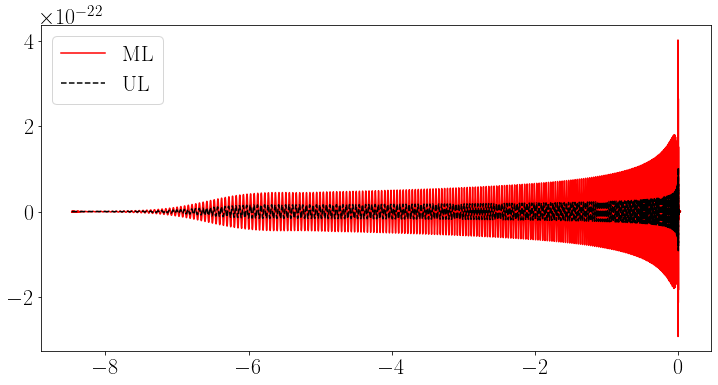

In [16]:
# Unlensed WF generation
m1=m2=10
init_prms = dict(f_low=20., f_high=None, f_ref=20., sample_rate=2048, wf_approximant="IMRPhenomXP", ifo_list=['H1', 'L1', 'V1'] )
lens_prms = dict(m_lens=1000, y_lens=0.1, z_lens=0)
cbc_prms = dict(mass_1=m1, mass_2=m2, a_1=0, a_2=0, tilt_1=0, tilt_2=0, phi_12=0, phi_jl=0, 
                luminosity_distance=2000, ra=3.14, dec=0.785, theta_jn=0, polarization=0,
                coa_phase=0, rwrap=0., trigger_time=1242529720)
prms = {**init_prms, **lens_prms, **cbc_prms}

## WF generation
res = lgw.lensed_pure_polarized_wf_gen(**prms)
lgw.print_dict(res)
# # Microlensed 
wf = res['lensed_TD_WF_hp']
plt.plot(wf.sample_times, wf, color='red', linestyle='solid', label='ML')
# # Unlensed 
wf = res['unlensed_TD_WF_hp']
plt.plot(wf.sample_times, wf, color='black', linestyle='--', label='UL')

# Comparison
plt.legend()
# plt.xlim(-0.2, 0.001)
plt.show()

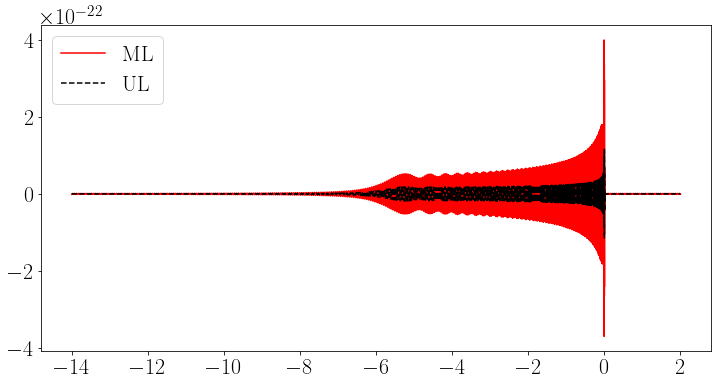

In [5]:
wg = GWSignalGeneration()

# Unlensed WF generation
m1=m2=10
init_prms = dict(f_low=20., f_high=None, f_ref=20., sample_rate=8192, wf_approximant="IMRPhenomXP", ifo_list=['H1', 'L1', 'V1'] )
lens_prms = dict(m_lens=1000, y_lens=0.1, z_lens=0)
cbc_prms = dict(mass_1=m1, mass_2=m2, a_1=0, a_2=0, tilt_1=0, tilt_2=0, phi_12=0, phi_jl=0, 
                luminosity_distance=2000, ra=3.14, dec=0.785, theta_jn=0, polarization=0,
                coa_phase=0, trigger_time=1242529720)
misc_prms = dict(rwrap=-2)                
prms = {**init_prms, **lens_prms, **cbc_prms, **misc_prms}

## WF generation
res = wg.generate_lensed_pure_polarized_waveforms(**prms)
# Microlensed 
wf = res['lensed_TD_WF_hp']
plt.plot(wf.sample_times, wf, color='red', linestyle='solid', label='ML')
# Unlensed 
wf = res['unlensed_TD_WF_hp']
plt.plot(wf.sample_times, wf, color='black', linestyle='--', label='UL')

# Comparison
plt.legend()
# plt.xlim(-0.2, 0.001)
plt.show()

In [7]:
res = lgw.lensed_pure_polarized_wf_gen(**prms)
wf_v1 = res['lensed_TD_WF_hp']
res = wg.generate_lensed_pure_polarized_waveforms(**prms)
wf_v2 = res['lensed_TD_WF_hp']
lgw.match_wfs_td(wf_v1, wf_v2)

(0.9990341464738857, 61696)

### 2. Simulated Injections check

In [8]:
# Microlensed WF generation with noise
m1=35
m2=30
init_prms = dict(f_start=20, f_low=20., f_high=None, f_ref=20., sample_rate=2048, wf_approximant="IMRPhenomXP", ifo_list=['H1', 'L1', 'V1'] )
psd_prms = dict(Noise=True, psd_H1='O4', psd_L1='O4', psd_V1='O4', gen_seed=50)
lens_prms = dict(m_lens=1e2, y_lens=0.1, z_lens=0)  # (m_lens=0 means unlensed)
cbc_prms = dict(mass_1=m1, mass_2=m2, a_1=0, a_2=0, tilt_1=0, tilt_2=0, phi_12=0, phi_jl=0, 
                luminosity_distance=4000, ra=3.14, dec=0.785, theta_jn=0, polarization=0,
                coa_phase=0, rwrap=0., trigger_time=1242529720)
prms = {**init_prms, **lens_prms, **cbc_prms, **psd_prms}
res = lgw.sim_lensed_noisy_wf_gen_with_snr(**prms)
lgw.print_dict(res)
mlwf_with_noise = res['noisy_ifo_signal']['H1']
mlwf_without_noise = res['pure_ifo_signal']['H1'] 

plt.plot(mlwf_with_noise.sample_times, mlwf_with_noise, color='black', linestyle='solid', label='ML WF: with noise (H1)')
plt.plot(mlwf_without_noise.sample_times, mlwf_without_noise, color='red', linestyle='solid', label='ML WF: w/o noise (H1)')   
plt.legend()
plt.show()

pure_polarized_wfs : {'hp': <pycbc.types.timeseries.TimeSeries object at 0x7f92e306f3d0>, 'hc': <pycbc.types.timeseries.TimeSeries object at 0x7f92e306f4f0>}
pure_ifo_signal : {'H1': <pycbc.types.timeseries.TimeSeries object at 0x7f931c3105b0>, 'L1': <pycbc.types.timeseries.TimeSeries object at 0x7f92e306f640>, 'V1': <pycbc.types.timeseries.TimeSeries object at 0x7f92e3072670>}
noisy_ifo_signal : {'H1': <pycbc.types.timeseries.TimeSeries object at 0x7f92e3074b50>, 'L1': <pycbc.types.timeseries.TimeSeries object at 0x7f92e3080ee0>, 'V1': <pycbc.types.timeseries.TimeSeries object at 0x7f92e30748e0>}
psd : {'H1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7f92e3b719a0>, 'L1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7f92e3145e20>, 'V1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7f92e307ceb0>}
signal_templates : {'H1': <pycbc.types.timeseries.TimeSeries object at 0x7f92e3080160>, 'L1': <pycbc.types.timeseries.TimeSeries object at 0x7f92e30ae160>

pure_polarized_wfs : {'hp': <pycbc.types.timeseries.TimeSeries object at 0x7f92e2e03820>, 'hc': <pycbc.types.timeseries.TimeSeries object at 0x7f92e2e03640>}
pure_ifo_signal : {'H1': <pycbc.types.timeseries.TimeSeries object at 0x7f92e2e03880>, 'L1': <pycbc.types.timeseries.TimeSeries object at 0x7f92e2f9c040>, 'V1': <pycbc.types.timeseries.TimeSeries object at 0x7f92e2f19dc0>}
noisy_ifo_signal : {'H1': <pycbc.types.timeseries.TimeSeries object at 0x7f92e2e00a60>, 'L1': <pycbc.types.timeseries.TimeSeries object at 0x7f92e2dff940>, 'V1': <pycbc.types.timeseries.TimeSeries object at 0x7f92e2f1a490>}
psd : {'H1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7f92e3b0e1c0>, 'L1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7f92e2f1a940>, 'V1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7f92e2e033a0>}
signal_templates : {'H1': <pycbc.types.timeseries.TimeSeries object at 0x7f92e2dffa60>, 'L1': <pycbc.types.timeseries.TimeSeries object at 0x7f92e2e1c2e0>

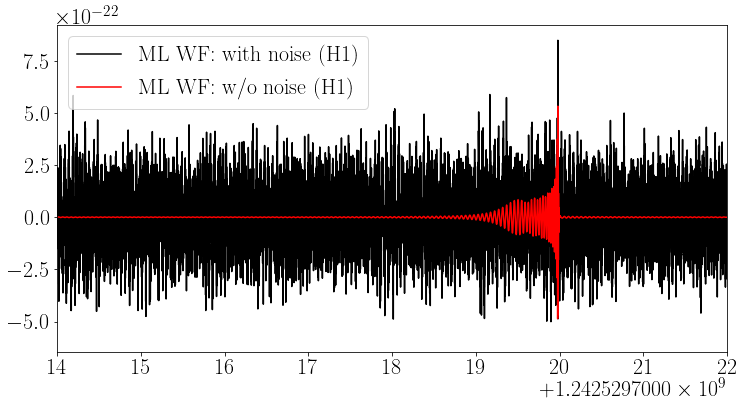

In [12]:
wg = GWSignalGeneration()

# Microlensed WF generation with noise
m1=35
m2=30
init_prms = dict(f_start=20, f_low=20., f_high=None, f_ref=20., sample_rate=2048, approximant="IMRPhenomXP", ifo_list=['H1', 'L1', 'V1'] )
psd_prms = dict(Noise=True, psd_H1='O4', psd_L1='O4', psd_V1='O4', noise_seed=50)
lens_prms = dict(m_lens=1e2, y_lens=0.1, z_lens=0)  # (m_lens=0 means unlensed)
cbc_prms = dict(mass_1=m1, mass_2=m2, a_1=0, a_2=0, tilt_1=0, tilt_2=0, phi_12=0, phi_jl=0, 
                luminosity_distance=4000, ra=3.14, dec=0.785, theta_jn=0, polarization=0,
                coa_phase=0, rwrap=-2, trigger_time=1242529720)
prms = {**init_prms, **lens_prms, **cbc_prms, **psd_prms}
res = wg.generate_simulated_lensed_noisy_gw_signals_with_snr_info(**prms)
wg.print_dict(res)
mlwf_with_noise = res['noisy_ifo_signal']['H1']
mlwf_without_noise = res['pure_ifo_signal']['H1'] 

plt.plot(mlwf_with_noise.sample_times, mlwf_with_noise, color='black', linestyle='solid', label='ML WF: with noise (H1)')
plt.plot(mlwf_without_noise.sample_times, mlwf_without_noise, color='red', linestyle='solid', label='ML WF: w/o noise (H1)')   
plt.legend()
plt.xlim(1242529714, 1242529722)
plt.show()

In [14]:
res = lgw.lensed_pure_polarized_wf_gen(**prms)
wf_v1 = res['lensed_TD_WF_hp']
res = wg.generate_lensed_pure_polarized_waveforms(**prms)
wf_v2 = res['lensed_TD_WF_hp']
wg.compute_pycbc_match(wf_v1, wf_v2)

(0.9996704410595189, 9601)

In [54]:
# wg = GWSignalGeneration()

# # Microlensed WF generation with noise
# m1=35
# m2=30
# init_prms = dict(f_start=20, f_low=20., f_high=None, f_ref=20., sample_rate=2048, approximant="IMRPhenomXP", ifo_list=['H1', 'L1', 'V1'] )
# psd_prms = dict(Noise=True, psd_H1='O4', psd_L1='O4', psd_V1='O4', noise_seed=50)
# lens_prms = dict(m_lens=1e2, y_lens=0.1, z_lens=0)  # (m_lens=0 means unlensed)
# cbc_prms = dict(mass_1=m1, mass_2=m2, a_1=0, a_2=0, tilt_1=0, tilt_2=0, phi_12=0, phi_jl=0, 
#                 luminosity_distance=4000, ra=3.14, dec=0.785, theta_jn=0, polarization=0,
#                 coa_phase=0, rwrap=-2, trigger_time=1242529720.1)
# prms = {**init_prms, **lens_prms, **cbc_prms, **psd_prms, 'save_data':True}
# res = wg.generate_simulated_lensed_noisy_gw_signals_with_snr_info(**prms)
# wg.print_dict(res)
# mlwf_with_noise = res['noisy_ifo_signal']['H1']
# mlwf_without_noise = res['pure_ifo_signal']['H1'] 

# plt.plot(mlwf_with_noise.sample_times, mlwf_with_noise, color='black', linestyle='solid', label='ML WF: with noise (H1)')
# plt.plot(mlwf_without_noise.sample_times, mlwf_without_noise, color='red', linestyle='solid', label='ML WF: w/o noise (H1)')   
# plt.legend()
# plt.xlim(1242529714, 1242529722)
# plt.show()

## Match Calculation

In [55]:
#!/usr/bin/env python
# coding: utf-8
# author: Bhushan Gadre

import numpy as np
import h5py

import pycbc.types as pt
import pycbc.waveform as pw
import pycbc.filter as _filter


def waveform_basis(hp, hc, psd=None, flow=None, ffinal=None):
    """Given (hp, hc), the function gives orthonormal basis vectors.
    From appendix B (eqns B3, B4) of
    https://journals.aps.org/prd/pdf/10.1103/PhysRevD.95.024010
    """
    hptilde = _filter.make_frequency_series(hp)
    hctilde = _filter.make_frequency_series(hc)
    sig1 = _filter.sigma(hp, psd, flow, ffinal)
    sig2 = _filter.sigma(hc, psd, flow, ffinal)

    proj = simple_inner(hptilde, hctilde, psd, flow, ffinal, sig1, sig2).real

    if isinstance(hp, pt.TimeSeries):
        hpp = pt.TimeSeries(hp.data / sig1, delta_t=hc.delta_t, epoch=hc._epoch)
        hper = pt.TimeSeries(hc.data / sig2, delta_t=hc.delta_t, epoch=hc._epoch)
    elif isinstance(hp, pt.FrequencySeries):
        hpp = pt.FrequencySeries(hp.data / sig1, delta_f=hc.delta_f, epoch=hc._epoch)
        hper = pt.FrequencySeries(hc.data / sig2, delta_f=hc.delta_f, epoch=hc._epoch)

    hper.data = (hper.data - proj * hpp.data) / np.sqrt(1 - proj * proj)
    hper.data /= _filter.sigma(hper, psd, flow, ffinal)

    return hpp, hper


def simple_inner(
    htilde, stilde, psd=None, flow=None, fhigh=None, norm1=None, norm2=None
):
    kmin, kmax = _filter.get_cutoff_indices(
        flow, fhigh, htilde.delta_f, (len(htilde) - 1) * 2
    )
    indices = slice(kmin, kmax)
    if norm1 and norm2:
        norm = norm1 * norm2
    else:
        norm1 = _filter.sigma(htilde, psd, flow, fhigh)
        norm2 = _filter.sigma(stilde, psd, flow, fhigh)
        norm = norm1 * norm2

    if psd:
        return (
            (
                np.conjugate(htilde.data[indices])
                * stilde.data[indices]
                / psd.data[indices]
            ).sum()
            * 4.0
            * psd.delta_f
            / norm
        )
    else:
        return (
            (np.conjugate(htilde.data[indices]) * stilde.data[indices]).sum()
            * 4.0
            * htilde.delta_f
            / norm
        )


def minmax_match_with_basis(
    basis1, basis2, psd=None, flow=None, fhigh=None, norm1=None, norm2=None
):
    """Return phases min-max matches from orthonormal bases.
    From appendix B (eqns B10 - B14) of
    https://journals.aps.org/prd/pdf/10.1103/PhysRevD.95.024010
    """
    match11 = _filter.matched_filter(basis1[0], basis2[0], psd, flow, fhigh, norm1)
    match12 = _filter.matched_filter(basis1[0], basis2[1], psd, flow, fhigh, norm2)
    match21 = _filter.matched_filter(basis1[1], basis2[0], psd, flow, fhigh, norm1)
    match22 = _filter.matched_filter(basis1[1], basis2[1], psd, flow, fhigh, norm2)

    a = (
        match11.real().data * match11.real().data
        + match21.real().data * match21.real().data
    )

    b = (
        match12.real().data * match12.real().data
        + match22.real().data * match22.real().data
    )

    c = (
        match11.real().data * match12.real().data
        + match21.real().data * match22.real().data
    )

    delta = (a - b) * (a - b) + 4 * c * c
    min_max = np.sqrt((a + b - delta) / 2.0)
    max_max = np.sqrt((a + b + delta) / 2.0)
    return min_max, max_max


# Example
approx = "IMRPhenomTPHM"
params = dict(
    mass1=50,
    mass2=5,
    f_lower=25,
    delta_f=1.0 / 64.0,
    spin1x=0.2,
    spin1y=0.03,
    spin1z=-0.6,
    spin2x=0.0,
    spin2y=-0.145,
    spin2z=0.4,
    inclination=np.pi / 3.0,
    delta_t=1.0 / 4096,
    approximant=approx,
)
hp, hc = pw.get_td_waveform(**params)

params["mass1"] = 49
params["mass2"] = 6
hp1, hc1 = pw.get_td_waveform(**params)

duration = 64 * 4096
hp.resize(duration)
hc.resize(duration)
hp1.resize(duration)
hc1.resize(duration)


basis = waveform_basis(hp, hc, None)  # , 20, 1024)
basis1 = waveform_basis(hp1, hc1, None)  # , 20, 1024)
min_max, max_max = minmax_match_with_basis(basis, basis1, None)  # , 20, 1024)

print("Time maxed min_max match with delta-t_c:")
print(min_max.max(), min_max.argmax())
print("Time maxed max_max match with delta-t_c:")
print(max_max.max(), max_max.argmax())

taper = "start"
params = dict(
    mass1=50,
    mass2=5,
    f_lower=10,
    delta_f=1.0 / 64.0,
    f_final=2048.0,
    spin1x=0.0,
    spin1y=0.0,
    spin1z=-0.6,
    spin2x=0.0,
    spin2y=0.0,
    spin2z=0.4,
    inclination=np.pi / 3.0,
    delta_t=1.0 / 4096,
    approximant="SEOBNRv4HM",
)
hp, hc = pw.get_td_waveform(**params)

params["mass1"] = 49
params["mass2"] = 6
hp1, hc1 = pw.get_td_waveform(**params)

duration = 64 * 4096
hp.resize(duration)
hc.resize(duration)
hp1.resize(duration)
hc1.resize(duration)
hp = pw.utils.taper_timeseries(hp, taper)
hc = pw.utils.taper_timeseries(hc, taper)
hp1 = pw.utils.taper_timeseries(hp1, taper)
hc1 = pw.utils.taper_timeseries(hc1, taper)


basis = waveform_basis(hp, hc, None, 10, 1024)
basis1 = waveform_basis(hp1, hc1, None, 10, 1024)
min_max, max_max = minmax_match_with_basis(basis, basis1, None, 10, 1024)

print("Time maxed min_max match with delta-t_c:")
print(min_max.max(), min_max.argmax())
print("Time maxed max_max match with delta-t_c:")
print(max_max.max(), max_max.argmax())
min_max, max_max = minmax_match_with_basis(basis1, basis, None, 10, 1024)

print("Time maxed min_max match with delta-t_c:")
print(min_max.max(), min_max.argmax())
print("Time maxed max_max match with delta-t_c:")
print(max_max.max(), max_max.argmax())

params = dict(
    mass1=50,
    mass2=5,
    f_lower=10,
    delta_f=1.0 / 64.0,
    f_final=2048.0,
    spin1x=0.0,
    spin1y=0.0,
    spin1z=-0.6,
    spin2x=0.0,
    spin2y=0.0,
    spin2z=0.4,
    inclination=np.pi / 3.0,
    delta_t=1.0 / 4096,
    approximant="SEOBNRv4_ROM",
)
fhp, fhc = pw.get_fd_waveform(**params)

params["mass1"] = 49
params["mass2"] = 6
fhp1, fhc1 = pw.get_fd_waveform(**params)

fbasis = waveform_basis(fhp, fhc, None, 10, 1024)
fbasis1 = waveform_basis(fhp1, fhc1, None, 10, 1024)
min_max, max_max = minmax_match_with_basis(fbasis, fbasis1, None, 10, 1024)

print("Time maxed min_max match with delta-t_c:")
print(min_max.max(), min_max.argmax())
print("Time maxed max_max match with delta-t_c:")
print(max_max.max(), max_max.argmax())


Time maxed min_max match with delta-t_c:
0.5534591798447316 261658
Time maxed max_max match with delta-t_c:
0.6672459228551265 261656
Time maxed min_max match with delta-t_c:
0.22158817658138213 259075
Time maxed max_max match with delta-t_c:
0.2215894566991886 259075
Time maxed min_max match with delta-t_c:
0.2215881765813821 3069
Time maxed max_max match with delta-t_c:
0.2215894566991886 3069


XLAL Error - SEOBNRv4ROM_Init_LALDATA (/home/conda/feedstock_root/build_artifacts/lalsimulation-split_1647252043927/work/lib/LALSimIMRSEOBNRv4ROM.c:1608): Unable to resolve data file SEOBNRv4ROM_v2.0.hdf5 in $LAL_DATA_PATH

XLAL Error - SEOBNRv4ROM_Init_LALDATA (/home/conda/feedstock_root/build_artifacts/lalsimulation-split_1647252043927/work/lib/LALSimIMRSEOBNRv4ROM.c:1608): I/O error
XLAL Error - SEOBNRv4ROMCore (/home/conda/feedstock_root/build_artifacts/lalsimulation-split_1647252043927/work/lib/LALSimIMRSEOBNRv4ROM.c:772): Error setting up SEOBNRv4ROM data - check your $LAL_DATA_PATH

XLAL Error - SEOBNRv4ROMCore (/home/conda/feedstock_root/build_artifacts/lalsimulation-split_1647252043927/work/lib/LALSimIMRSEOBNRv4ROM.c:772): Generic failure
XLAL Error - XLALSimInspiralChooseFDWaveform (/home/conda/feedstock_root/build_artifacts/lalsimulation-split_1647252043927/work/lib/LALSimInspiral.c:2357): Internal function call failed: Generic failure


RuntimeError: Internal function call failed: Generic failure